In [ ]:
%tensorflow_version 2.x

import os
import tensorflow
from tensorflow import keras

print(tensorflow.__version__)
print(keras.__version__)

2.4.1
2.4.0


In [ ]:
import zipfile

drive_file = "/content/drive/MyDrive/Colab Data/MiniProject21/Custom.zip"
unzipper = zipfile.ZipFile(drive_file, "r")
unzipper.extractall("/tmp/train")
unzipper.close()

drive_file = "/content/drive/MyDrive/Colab Data/MiniProject21/CustomTest.zip"
unzipper = zipfile.ZipFile(drive_file, "r")
unzipper.extractall("/tmp/test")
unzipper.close()

In [ ]:
TRAIN_DIR = "/tmp/train/Custom"
VAL_DIR = "/tmp/test/CustomTest"

print("Train count:", len(os.listdir(TRAIN_DIR)))
print("Test count:", len(os.listdir(VAL_DIR)))

CLASSES = os.listdir(TRAIN_DIR)
CLASSES.sort()
CLASS_COUNT = len(CLASSES)
print(CLASSES)

Train count: 40
Test count: 40
['aloo_paratha', 'bhel', 'biryani', 'burger', 'butter_naan', 'chai', 'chapati', 'chicken_wings', 'chole_bhature', 'club_sandwich', 'cup_cakes', 'dal_makhani', 'dhokla', 'french_fries', 'fried_rice', 'gajar_halwa', 'garlic_bread', 'grilled_sandwich', 'gulab_jamun', 'hot_dog', 'idli', 'jalebi', 'kaathi_rolls', 'kadai_paneer', 'kulfi', 'masala_dosa', 'momos', 'noodles', 'omelette', 'paani_puri', 'pakode', 'pav_bhaji', 'pizza', 'poha', 'samosa', 'soup', 'spring_roll', 'strawberry_cake', 'vada_pav', 'waffles']


In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2021-03-25 05:37:11--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.99.128, 74.125.20.128, 74.125.142.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.99.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   151MB/s    in 0.6s    

2021-03-25 05:37:12 (151 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import Model


In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

weights_file = "/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"

# Define InceptionV3 object
inception = InceptionV3(input_shape=(224, 224, 3),  # Input image size
                        include_top=False,  # We will configure top layer manually
                        weights=None)  # we will used the downloaded weights file
inception.load_weights(weights_file)

# The model is used for feature extraction
# Hence we dont need to train the model again
for layer in inception.layers:
    layer.trainable = False


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [ ]:
# defining the last layer
last_layer = inception.get_layer("mixed7")
print("Last layer:", last_layer)

last_layer = last_layer.output

Last layer: <tensorflow.python.keras.layers.merge.Concatenate object at 0x7fcd4a7da890>


In [ ]:
# Flattening the last_layer into one dimension
x = layers.Flatten()(last_layer)

# Fully connected layer with 2048 nodes
# x = layers.Dense(2048, activation="relu")(x)

# Fully connected layer with 1024 nodes
x = layers.Dense(1024, activation="relu")(x)

# Dropout layer to prevent overfitting
# Dropout rate of 0.3 i..e 30% of nodes will be randomly deactivated
x = layers.Dropout(0.3)(x)

# Output layer
# Softmax activation: sum of probabilities of all classes will be 1
output_layer = layers.Dense(CLASS_COUNT, activation="softmax")(x)

In [ ]:
model = Model(inception.input, output_layer)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
from tensorflow.keras.optimizers import RMSprop

model.compile(optimizer=RMSprop(lr=0.0001),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Applying various filters on the image so that the model never sees the same 
# image twice and thus preventing overfitting
train_format = ImageDataGenerator(rescale=1/255,  # pixel value between 0 to 1
                                  rotation_range=40,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True)

val_format = ImageDataGenerator(rescale=1/255)

train_data_generator = train_format.flow_from_directory(TRAIN_DIR,
                                                        target_size=(224, 224),
                                                        class_mode="categorical")

val_data_generator = val_format.flow_from_directory(VAL_DIR,
                                                    target_size=(224, 224),
                                                    class_mode="categorical")

Found 10430 images belonging to 40 classes.
Found 2923 images belonging to 40 classes.


In [ ]:
result = model.fit(train_data_generator,
                   epochs=10,
                   validation_data=val_data_gen erator,
                   verbose=2)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 10. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 12 bytes but only got 10. Skipping tag 42037
  " Skipping tag %s" % (size, len(data), tag)


Epoch 1/10


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


326/326 - 2204s - loss: 1.2086 - acc: 0.6508 - val_loss: 1.2421 - val_acc: 0.7000
Epoch 2/10
Epoch 1/10
326/326 - 2181s - loss: 1.1695 - acc: 0.6672 - val_loss: 1.4056 - val_acc: 0.6887
Epoch 3/10
Epoch 1/10
326/326 - 2190s - loss: 1.1031 - acc: 0.6897 - val_loss: 1.3386 - val_acc: 0.7000
Epoch 4/10
Epoch 1/10
326/326 - 2177s - loss: 1.0775 - acc: 0.6996 - val_loss: 1.2357 - val_acc: 0.7355
Epoch 5/10
Epoch 1/10
326/326 - 2180s - loss: 1.0494 - acc: 0.7028 - val_loss: 1.7329 - val_acc: 0.6685
Epoch 6/10
Epoch 1/10
326/326 - 2163s - loss: 1.0058 - acc: 0.7174 - val_loss: 1.5008 - val_acc: 0.7082
Epoch 7/10
Epoch 1/10
326/326 - 2185s - loss: 1.0061 - acc: 0.7221 - val_loss: 1.4802 - val_acc: 0.7191
Epoch 8/10
Epoch 1/10
326/326 - 2187s - loss: 0.9722 - acc: 0.7274 - val_loss: 1.5146 - val_acc: 0.7143
Epoch 9/10
Epoch 1/10
326/326 - 2184s - loss: 0.9655 - acc: 0.7277 - val_loss: 1.3381 - val_acc: 0.7403
Epoch 10/10
Epoch 1/10
326/326 - 2168s - loss: 0.9271 - acc: 0.7405 - val_loss: 1.5857

In [ ]:
# save model

model.save("/content/drive/MyDrive/Colab Data/MiniProject21/pre_trained_tf1.h5")

In [ ]:
# Retrive saved model

from tensorflow import keras

model = keras.models.load_model("/content/drive/MyDrive/Colab Data/MiniProject21/pre_trained1.h5")

In [ ]:
from tensorflow.keras.optimizers import SGD

flag = False

for layer in inception.layers:
    if flag:
        layer.trainable = True

    if layer.name == "mixed6":  # will make layers after layer6 i..e. layer7 layers trainable
        flag = True


model.compile(loss="categorical_crossentropy",
              optimizer=SGD(lr=0.00001, momentum=0.9),
              metrics=["accuracy"])

In [ ]:
result = model.fit(train_data_generator,
                   epochs=10,
                   validation_data=val_data_generator,
                   verbose=2)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 10. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 12 bytes but only got 10. Skipping tag 42037
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


326/326 - 2221s - loss: 1.1329 - accuracy: 0.6793 - val_loss: 0.7237 - val_accuracy: 0.7862
Epoch 2/10
326/326 - 2208s - loss: 1.0022 - accuracy: 0.7145 - val_loss: 0.6959 - val_accuracy: 0.7964
Epoch 3/10
326/326 - 2217s - loss: 0.9550 - accuracy: 0.7227 - val_loss: 0.6824 - val_accuracy: 0.7975
Epoch 4/10
326/326 - 2212s - loss: 0.9412 - accuracy: 0.7267 - val_loss: 0.6749 - val_accuracy: 0.7988
Epoch 5/10
326/326 - 2213s - loss: 0.9354 - accuracy: 0.7267 - val_loss: 0.6693 - val_accuracy: 0.8005
Epoch 6/10
326/326 - 2200s - loss: 0.9148 - accuracy: 0.7299 - val_loss: 0.6664 - val_accuracy: 0.8016
Epoch 7/10
326/326 - 2200s - loss: 0.9179 - accuracy: 0.7325 - val_loss: 0.6628 - val_accuracy: 0.8043
Epoch 8/10
326/326 - 2180s - loss: 0.9140 - accuracy: 0.7335 - val_loss: 0.6592 - val_accuracy: 0.8057
Epoch 9/10
326/326 - 2192s - loss: 0.9040 - accuracy: 0.7399 - val_loss: 0.6559 - val_accuracy: 0.8060
Epoch 10/10
326/326 - 2162s - loss: 0.8952 - accuracy: 0.7408 - val_loss: 0.6542 - v

<Figure size 432x288 with 0 Axes>

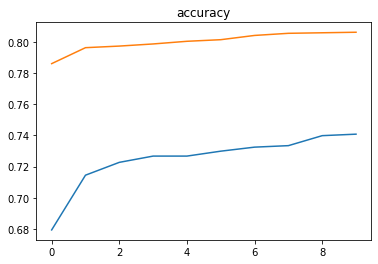

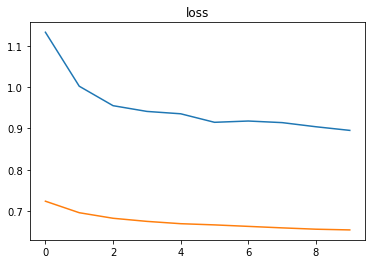

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt


accuracy = result.history["accuracy"]
val_accuracy = result.history["val_accuracy"]

loss = result.history["loss"]
val_loss = result.history["val_loss"]

epochs = range(len(accuracy))

plt.plot(epochs, accuracy)
plt.plot(epochs, val_accuracy)
plt.title("accuracy")
plt.figure()

plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title("loss")
plt.figure()

In [ ]:
import tensorflow as tf

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open("/content/drive/MyDrive/Colab Data/MiniProject21/FoodClassifier40_81.tflite", "wb") as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpa3df0oyj/assets


In [ ]:
interpreter = tf.lite.Interpreter(model_path="/content/drive/MyDrive/Colab Data/MiniProject21/FoodClassifier40_81.tflite")
interpreter.allocate_tensors()

# Print input shape and type
inputs = interpreter.get_input_details()
print('{} input(s):'.format(len(inputs)))
for i in range(0, len(inputs)):
    print('{} {}'.format(inputs[i]['shape'], inputs[i]['dtype']))

# Print output shape and type
outputs = interpreter.get_output_details()
print('\n{} output(s):'.format(len(outputs)))
for i in range(0, len(outputs)):
    print('{} {}'.format(outputs[i]['shape'], outputs[i]['dtype']))

1 input(s):
[  1 224 224   3] <class 'numpy.float32'>

1 output(s):
[ 1 40] <class 'numpy.float32'>
